In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB

In [2]:
clothing = pd.read_csv("Womens Clothing E-Commerce Reviews.csv") #reading the data set
clothing.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Category,Recommended IND
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,0,Initmates,Intimate,Intimates,1
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,4,General,Dresses,Dresses,1
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,0
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,General Petite,Bottoms,Pants,1
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,6,General,Tops,Blouses,1


## Find any null values are present or not, If present remove those data.

In [3]:
clothing.isna().sum() #checking for null values

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Positive Feedback Count       0
Division Name                14
Department Name              14
Category                     14
Recommended IND               0
dtype: int64

In [4]:
clothing.drop('Unnamed: 0', axis=1, inplace=True) ##irrelevant column

In [5]:
clothing.dropna(inplace=True)
clothing=clothing.drop_duplicates()
clothing.isna().sum() ##dropping null and duplicate values

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Positive Feedback Count    0
Division Name              0
Department Name            0
Category                   0
Recommended IND            0
dtype: int64

## Remove the data that have less than 5 reviews.

In [6]:
n = clothing['Clothing ID'].value_counts()
remove = n[n < 5].index
clothing = clothing[~clothing['Clothing ID'].isin(remove)] ##removing items with less than 5 reviews

## Clean the data and remove the special characters and replace the contractions with its expansion. Convert the uppercase character to lower case. Also, remove the punctuations.

In [7]:
# mapping contractions to expansions
contractions = {
"a'ight":"alright",
"ain't":"are not",
"amn't":"am not",
"aren't":"are not",
"can't":"cannot",
"'cause": "because",
"could've":"could have",
"couldn't":"could not",
"couldn't've":"could not have",
"daren't":"dare not",
"daresn't":"dare not",
"dasn't":"dare not",
"didn't":"did not",
"doesn't":"does not",
"don't":"do not",
"everybody's":"everybody is",
"everyone's":"everyone is",
"giv'n":"given",
"gonna":"going to",
"gon't":"go not", 
"gotta":"got to",
"hadn't":"had not",
"had've":"had have",
"hasn't":"has not",
"haven't":"have not",
"he'd":"he had", 
"he'll":"he will",
"he's":"he is",
"here's":"here is",
"how'd":"how did",
"how'll":"how will",
"how're":"how are",
"how's":"how is",
"I'd":"I had",
"I'd've":"I would have",
"I'd'nt":"I would not",
"I'd'nt've":"I would not have",
"I'll":"I will",
"I'm":"I am",
"I've":"I have",
"isn't":"is not",
"it'd":"it would",
"it'll":"it will",
"it's":"it is",
"let's":"let us",
"ma'am":"madam",
"mayn't":"may not",
"may've":"may have",
"mightn't":"might not",
"might've":"might have",
"mustn't":"must not",
"mustn't've":"must not have",
"must've":"must have",
"needn't":"need not",
"needn't've":"need not have",
"o'clock":"of the clock",
"oughtn't":"ought not",
"oughtn't've":"ought not have",
"shan't":"shall not",
"she'd":"she would",
"she'll":"she will",
"she's":"she is",
"should've":"should have",
"shouldn't":"should not",
"shouldn't've":"should not have",
"somebody's":"somebody is",
"someone's":"someone is",
"something's":"something is",
"so're":"so are",
"so’s":"so is",
"so’ve":"so have",
"that'll":"that will",
"that're":"that are",
"that's":"that is",
"that'd":"that would",
"there'd":"there would",
"there'll":"there will",
"there're":"there are",
"there's":"there is",
"these're":"these are",
"these've":"these have",
"they'd":"they would",
"they'll":"they will",
"they're":"they are",
"they've":"they have",
"this's":"this is",
"those're":"those are",
"those've":"those have",
"to've":"to have",
"wasn't":"was not",
"we'd":"we would",
"we'd've":"we would have",
"we'll":"we will",
"we're":"we are",
"we've":"we have",
"weren't":"were not",
"what'd":"what did",
"what'll":"what will",
"what're":"what are",
"what's":"what is",
"what've":"what have",
"when's":"when is",
"where'd":"where did",
"where'll":"where will",
"where're":"where are",
"where's":"where is",
"where've":"where have",
"which'd":"which would",
"which'll":"which will",
"which're":"which are",
"which's":"which is",
"which've":"which have",
"who'd":"who would",
"who'd've":"who would have",
"who'll":"who will",
"who're":"who are",
"who's":"who is",
"who've":"who have",
"why'd":"why did",
"why're":"why are",
"why's":"why is",
"won't":"will not",
"would've":"would have",
"wouldn't":"would not",
"wouldn't've":"would not have",
"y'at":"you at",
"yes’m":"yes madam",
"you'd":"you would",
"you'll":"you will",
"you're":"you are",
"you've":"you have"}

In [8]:
def cont_to_exp(x):
    if type(x) is str:
        x = x.replace('\\','')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x
        ##helper function to expand contractions

In [9]:
clothing["Review Text"] = clothing["Review Text"].apply(lambda x:cont_to_exp(x)) ##expanding contractions

In [10]:
clothing["Review Text"] = clothing["Review Text"].str.lower() ##converting review text to lowercase

In [11]:
def remove_special(x):
    new_text= re.sub('[^\w\s]','', x)
    return new_text 
    ##helper function to remove special character using regex

In [12]:
clothing["Review Text"] = clothing["Review Text"].apply(lambda x:remove_special(x)) ##removing special characters using helper function

## Separate the columns into dependent and independent variables (or features and labels). Then you split those variables into train and test sets (80:20).

In [13]:
relevant_from_df = clothing[['Clothing ID','Review Text','Recommended IND']]
relevant_from_df['Polarity'] = clothing['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

<ipython-input-13-6a56c4377098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_from_df['Polarity'] = clothing['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [14]:
X = relevant_from_df['Polarity'] 
Y = relevant_from_df['Recommended IND'] ## taking Polarity as independent and Recommended IND as dependent 

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=501) ##Splittinh into 80-20 train-test split

## Apply the Naïve Bayes Classification Algorithm on Sentiment category to predict if item is recommended

In [16]:
gnb = GaussianNB()
gnb.fit(X_train.values.reshape(-1, 1), Y_train) ##fitting values into Guassian Naive Bayes classifier 

GaussianNB()

In [17]:
Y_pred = gnb.predict(X_test.values.reshape(-1, 1)) ##predicitng on X_test

In [18]:
acc = accuracy_score(Y_pred, Y_test) 
print("Accuracy = ",acc) ##checking accuracy of model

Accuracy =  0.8266775332790003


## Tabulate accuracy in terms of precision,recall and F1 score.

In [19]:
print(classification_report(Y_test, Y_pred)) ##tabulating accuracy in terms of precision, recall and F1 score

              precision    recall  f1-score   support

           0       0.66      0.09      0.16       668
           1       0.83      0.99      0.90      3013

    accuracy                           0.83      3681
   macro avg       0.75      0.54      0.53      3681
weighted avg       0.80      0.83      0.77      3681



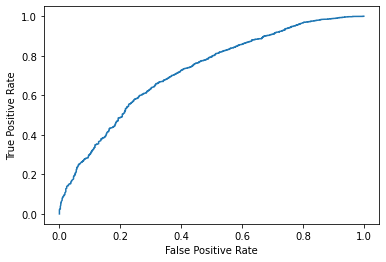

In [27]:
Y_pred_proba = gnb.predict_proba(X_test.values.reshape(-1, 1))[:, 1]
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### The model performs fairly accurately having a score of nearly 83%. The ROC Curve nears 1 which means that the model is decent at classifying the data.

